In [25]:
import pyspark
from pyspark.sql import SparkSession
import glob
from pyspark.sql import functions
from pyspark.sql.functions import input_file_name, substring, regexp_extract, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
%config IPCompleter.greedy=True

In [26]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from glob import glob

from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType
from pyspark.sql import functions
from pyspark.sql.functions import input_file_name, substring, regexp_extract, col
import pandas as pd
import ast
import re

from pyspark.sql.functions import col
spark = SparkSession.builder\
         .master("local")\
         .appName("StockPrediction")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()

**Load Data**

In [27]:
schema = StructType([StructField("date",TimestampType(),True),
                     StructField("open",DoubleType(),True),
                     StructField("high",DoubleType(),True),
                     StructField("low",DoubleType(),True),
                     StructField("close",DoubleType(),True),
                     StructField("volume",DoubleType(),True)])

In [28]:
path = '/Users/d0d02tr/Desktop/data/*.txt'

In [29]:
stock_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .schema(schema) \
    .json(path) \
    .withColumn("company", regexp_extract(input_file_name(), "/([^/]+)$", 1))

**Read data into Dataframe with file names also as an**

In [30]:
stock_df.show()

+-------------------+--------+--------+--------+--------+------+--------------------+
|               date|    open|    high|     low|   close|volume|             company|
+-------------------+--------+--------+--------+--------+------+--------------------+
|2022-10-06 09:15:00|82655.05| 83817.8|82655.05|83575.25| 274.0|MRF._hourly_data_...|
|2022-10-06 10:15:00|83575.25|83764.95| 83380.8| 83540.0|  36.0|MRF._hourly_data_...|
|2022-10-06 11:15:00| 83540.0| 83600.0| 83200.0| 83321.1| 205.0|MRF._hourly_data_...|
|2022-10-06 12:15:00| 83321.1| 83321.1| 83000.0| 83051.0|  39.0|MRF._hourly_data_...|
|2022-10-06 13:15:00| 83051.0| 83145.9|82501.05|82501.05|  43.0|MRF._hourly_data_...|
|2022-10-06 14:15:00|82501.05|82884.05|82251.55|82523.65| 136.0|MRF._hourly_data_...|
|2022-10-06 15:15:00|82523.65| 82706.3|82110.35|82543.65|  85.0|MRF._hourly_data_...|
|2022-10-07 09:15:00|82543.65| 82934.2| 81831.0|82182.75| 104.0|MRF._hourly_data_...|
|2022-10-07 10:15:00|82182.75| 82235.4|81812.85| 82020

In [31]:
stock_df = stock_df.withColumn('symbol', functions.split('company', '_hourly')[0]).withColumn('symbol', functions.expr("replace(symbol, '%20', ' ')"))

In [32]:
# Convert the 'date' column to datetime
dataframe = stock_df.withColumn("date", functions.to_timestamp(functions.col("date"), "yyyy-MM-dd HH:mm:ss"))

# Get the minimum date
min_date = dataframe.agg(functions.min("date")).collect()[0][0]

# Calculate the number of hours since the start
dataframe = dataframe.withColumn("duration", (functions.col("date").cast("long") - functions.lit(min_date).cast("long")) / 3600)
dataframe.show()

+-------------------+--------+--------+--------+--------+------+--------------------+------+--------+
|               date|    open|    high|     low|   close|volume|             company|symbol|duration|
+-------------------+--------+--------+--------+--------+------+--------------------+------+--------+
|2022-10-06 09:15:00|82655.05| 83817.8|82655.05|83575.25| 274.0|MRF._hourly_data_...|  MRF.| 32976.0|
|2022-10-06 10:15:00|83575.25|83764.95| 83380.8| 83540.0|  36.0|MRF._hourly_data_...|  MRF.| 32977.0|
|2022-10-06 11:15:00| 83540.0| 83600.0| 83200.0| 83321.1| 205.0|MRF._hourly_data_...|  MRF.| 32978.0|
|2022-10-06 12:15:00| 83321.1| 83321.1| 83000.0| 83051.0|  39.0|MRF._hourly_data_...|  MRF.| 32979.0|
|2022-10-06 13:15:00| 83051.0| 83145.9|82501.05|82501.05|  43.0|MRF._hourly_data_...|  MRF.| 32980.0|
|2022-10-06 14:15:00|82501.05|82884.05|82251.55|82523.65| 136.0|MRF._hourly_data_...|  MRF.| 32981.0|
|2022-10-06 15:15:00|82523.65| 82706.3|82110.35|82543.65|  85.0|MRF._hourly_data_.

In [33]:
dataframe = dataframe.select("symbol", "date", "duration", "open", "high", "low", "close", "volume").drop("company").orderBy("date")

**Average close price - This should be done per day, hourly basis doenst make sense**

In [34]:
average_close_price = dataframe.groupBy("symbol").agg(functions.mean("close").alias("avg_close"))

**Volatility Analysis - This is also giving deviation every hour**

**Find total number of companies**

In [35]:
from pyspark.sql import Window


In [36]:

from pyspark.sql.functions import *
from pyspark.sql import functions as F

stock_df= stock_df.withColumn("date",to_date(('date')))

In [37]:
window_spec = Window.partitionBy("symbol").orderBy("date")
stock_df_with_row_number = stock_df.withColumn("row_number", F.row_number().over(window_spec))
trained_df = stock_df_with_row_number.filter(F.col("row_number") <= 1000)

In [38]:

# Calculate the partition number based on 30 rows chunks
trained_df_partitioned = trained_df.withColumn("partition", ((F.col("row_number") - 1) / 30).cast("integer"))

# Group by 'partition' and calculate the average for each double column
averages_df = trained_df_partitioned.groupBy("partition", "symbol").agg(
    F.avg("open").alias("avg_open"),
    F.avg("high").alias("avg_high"),
    F.avg("low").alias("avg_low"),
    F.avg("close").alias("avg_close"),
    F.avg("volume").alias("avg_volume"),
    F.max("date").alias("max_date")
).drop('row_number')
averages_df = averages_df.withColumn("partition", col("partition")+1)
# Show the result
averages_df_updated = averages_df.withColumn("marker",F.when((F.col("partition") % 4 == 0), "test").otherwise("train"))


from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol="symbol", outputCol="category_symbol")
model = string_indexer.fit(averages_df_updated)
averages_df_updated = model.transform(averages_df_updated)


train_df = averages_df_updated.filter(col("marker")=="train")
test_df = averages_df_updated.filter(col("marker")=="test")


In [39]:
window_spec = Window.partitionBy("symbol").orderBy("partition")


# Add a row number column within each group
train_df = train_df.withColumn("row_num", F.row_number().over(window_spec))
# Group by 'symbol' and 'row_num' and aggregate the double columns
train_df = train_df.groupBy("symbol","category_symbol", F.floor((F.col("row_num") - 1) / 3).alias("group_num")).agg(
    F.avg("avg_open").alias("avg_open"),
    F.avg("avg_high").alias("avg_high"),
    F.avg("avg_low").alias("avg_low"),
    F.avg("avg_close").alias("avg_close"),
    F.avg("avg_volume").alias("avg_volume"),
    F.max("max_date").alias("max_date")
)


In [40]:
window_spec = Window.partitionBy("symbol").orderBy("partition")

# Add a row number column within each group
test_df = test_df.withColumn("row_num", F.row_number().over(window_spec))

# Group by 'symbol' and 'row_num' and aggregate the double columns
test_df = test_df.groupBy("symbol","category_symbol", F.floor((F.col("row_num") - 1) / 1).alias("group_num")).agg(
    F.avg("avg_open").alias("avg_open"),
    F.avg("avg_high").alias("avg_high"),
    F.avg("avg_low").alias("avg_low"),
    F.avg("avg_close").alias("avg_close"),
    F.avg("avg_volume").alias("avg_volume"),
    F.max("max_date").alias("max_date")
)


In [41]:
join_columns = ["category_symbol", "group_num"]

# Perform the join
merged_df = train_df.join(test_df.select("category_symbol", "group_num", col("avg_high").alias("avg_high_test"), col("max_date").alias("date")), on=join_columns, how="inner")

# Show the resulting DataFrame
merged_df.show()

+---------------+---------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+----------+-------------------+----------+
|category_symbol|group_num|              symbol|           avg_open|           avg_high|            avg_low|          avg_close|          avg_volume|  max_date|      avg_high_test|      date|
+---------------+---------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+----------+-------------------+----------+
|            0.0|        0|                MRF.|  66504.09444444445|  66646.37055555555|  66339.78333333334|  66468.12444444445|   79.25555555555555|2019-01-17|  65897.16666666667|2019-01-24|
|            0.0|        1|                MRF.| 61044.006111111106|  61205.20444444444|  60720.47222222222| 60881.657222222224|   85.66666666666667|2019-02-11|  55766.28999999999|2019-02-18|
|            0.0|        2|             

In [42]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Assuming merged_df is the DataFrame with the specified schema

# Split the data into training and testing sets
# companies = merged_df.select("category_symbol").distinct().rdd.flatMap(lambda x: x).collect()
# num_companies = len(companies)

# Assuming 80% for training and 20% for testing
train_percentage = 0.8
# num_train_companies = int(num_companies * train_percentage)

# Randomly select companies for training
# train_companies = merged_df.sample(False, train_percentage, seed=42).rdd.flatMap(lambda x: x).collect()
train_df, test_df = merged_df.randomSplit([0.8, 0.2], seed=42)


# Create train and test DataFrames
# train_df = merged_df.filter(col("category_symbol").isin(train_companies))
# test_df = merged_df.filter(~col("category_symbol").isin(train_companies))

# Define features and target column
features = ["category_symbol", "avg_open", "avg_high", "avg_low", "avg_close", "avg_volume"]
target = "avg_high_test"

# Create a linear regression model
lr = LinearRegression(featuresCol="features", labelCol=target)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

# Fit the model on the training data
lr_model = lr.fit(train_df)

# Make predictions on the test data
predictions = lr_model.transform(test_df)



23/12/08 21:29:04 WARN Instrumentation: [48ec7b47] regParam is zero, which might cause numerical instability and overfitting.


In [43]:
# Print RMSE loss
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

Root Mean Squared Error (RMSE) on test data: 482.83407992369666


In [44]:
from pyspark.sql import Row

# Create an empty list to store RMSE results
symbol_rmse_list = []
symbols = predictions.select("symbol").distinct().rdd.flatMap(lambda x: x).collect()

for symbol in symbols:
    # Filter predictions for the current symbol
    symbol_predictions = predictions.filter(col("symbol") == symbol)

    # Check if there are predictions for the current symbol
    if symbol_predictions.count() > 0:
        # Calculate RMSE for the current symbol
        symbol_rmse = evaluator.evaluate(symbol_predictions)

        # Append the results to the list
        symbol_rmse_list.append(Row(symbol=symbol, rmse=symbol_rmse))

# Create a DataFrame from the list
symbol_rmse_df = spark.createDataFrame(symbol_rmse_list)

# Show the DataFrame with RMSE for each symbol
symbol_rmse_df.show(truncate=False)


+------------------------------+------------------+
|symbol                        |rmse              |
+------------------------------+------------------+
|MRF.                          |964.1641914995474 |
|PAN INDIA CORPORATION.        |32.455018995464584|
|PANASONIC CARBON INDIA CO.LTD.|39.66949136368884 |
|PANKAJ PIYUSH TRADE _ INV.    |10.158771347750474|
|TECH MAHINDRA.                |21.157015497333646|
+------------------------------+------------------+



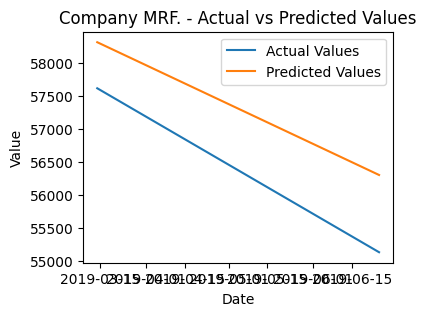

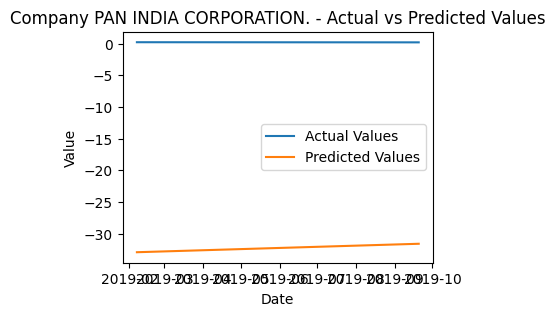

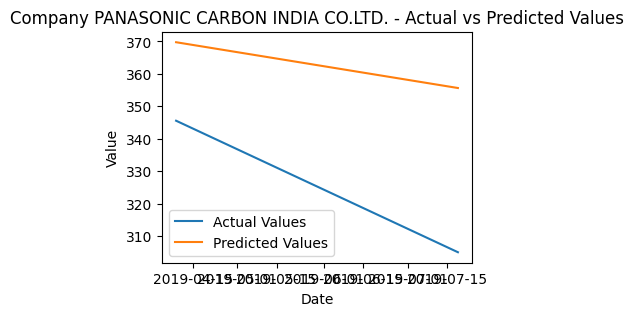

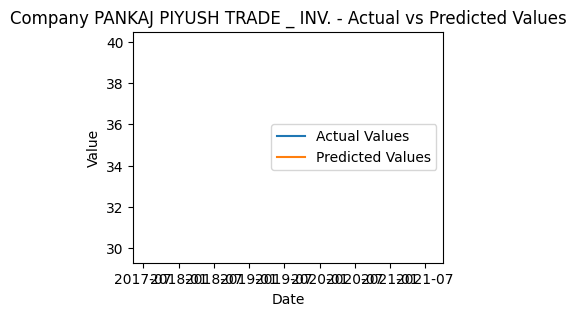

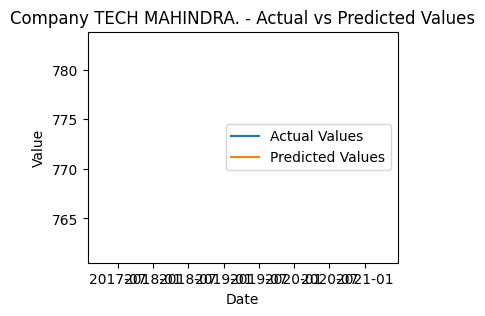

In [45]:


# Plot separate line plots for predictions and true values for each company
unique_companies = test_df.select("symbol").distinct().collect()

for company_row in unique_companies:
    company_index = company_row["symbol"]

    # Filter data for the current company
    company_data = predictions.filter(col("symbol") == company_index).orderBy("group_num")

    # Extract actual and predicted values
    actual_values = company_data.select("avg_high_test").rdd.map(lambda x: x[0]).collect()
    predicted_values = company_data.select("prediction").rdd.map(lambda x: x[0]).collect()

    # Plot the line plot for the current company
    plt.figure(figsize=(4, 3))
    plt.plot(company_data.select("date").rdd.map(lambda x: x[0]).collect(), actual_values, label="Actual Values")
    plt.plot(company_data.select("date").rdd.map(lambda x: x[0]).collect(), predicted_values, label="Predicted Values")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"Company {company_index} - Actual vs Predicted Values")
    plt.legend()
    plt.show()

In [46]:
!pip3 install shap
!pip3 install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


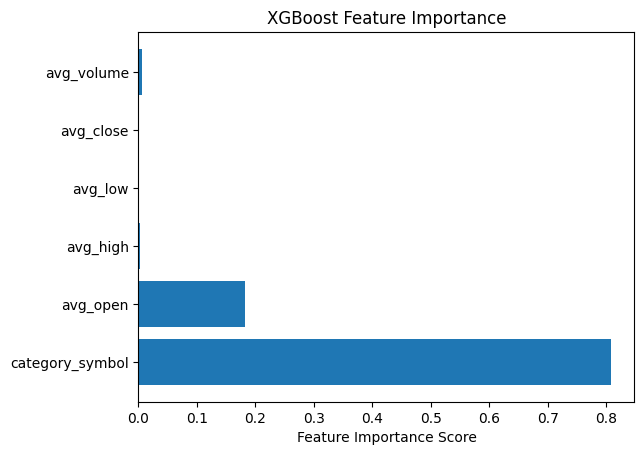

In [47]:
from pyspark.ml.regression import GBTRegressor
import xgboost
import shap
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Assuming merged_df is the DataFrame with the specified schema

# Split the data into training and testing sets
train_df, test_df = merged_df.randomSplit([0.8, 0.2], seed=42)

# Define features and target column
features = ["category_symbol", "avg_open", "avg_high", "avg_low", "avg_close", "avg_volume"]
target = "avg_high_test"

# Create a StringIndexer for the target column
indexer = StringIndexer(inputCol=target, outputCol="label")

# Create an XGBoost regressor
xgb_regressor = xgboost.XGBRegressor(
    objective="reg:squarederror",
    num_round=100,
    max_depth=3,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
)

# Create a PySpark MLlib VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Create a PySpark MLlib GBTRegressor
xgb_model = GBTRegressor(featuresCol="features", labelCol="label")

# Create a PySpark MLlib Pipeline
pipeline = Pipeline(stages=[indexer, assembler, xgb_model])

# Fit the pipeline on the training data
model = pipeline.fit(train_df)

# Make predictions on the test data
predictions = model.transform(test_df)

# Extract feature importance scores
feature_importance_scores = model.stages[-1].featureImportances.toArray()

# Plot feature importance
plt.barh(features, feature_importance_scores)
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.show()



In [48]:
# Print RMSE loss
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

Root Mean Squared Error (RMSE) on test data: 28189.051405601447
